In [1]:
import numpy as numpy 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("../safetronics/human_vital_signs_dataset_2024.csv")

In [3]:
df.head()

,Patient ID,Heart Rate,Respiratory Rate,Timestamp,Body Temperature,Oxygen Saturation,Systolic Blood Pressure,Diastolic Blood Pressure,Age,Gender,Weight (kg),Height (m),Derived_HRV,Derived_Pulse_Pressure,Derived_BMI,Derived_MAP,Risk Category
0,1,60,12,2024-07-19 21:53:45.729841,36.861707,95.702046,124,86,37,Female,91.541618,1.679351,0.121033,38,32.459031,98.666667,High Risk
1,2,63,18,2024-07-19 21:52:45.729841,36.511633,96.689413,126,84,77,Male,50.704921,1.992546,0.117062,42,12.771246,98.000000,High Risk
2,3,63,15,2024-07-19 21:51:45.729841,37.052049,98.508265,131,78,68,Female,90.316760,1.770228,0.053200,53,28.821069,95.666667,Low Risk
3,4,99,16,2024-07-19 21:50:45.729841,36.654748,95.011801,118,72,41,Female,96.006188,1.833629,0.064475,46,28.554611,87.333333,High Risk
4,5,69,16,2024-07-19 21:49:45.729841,36.975098,98.623792,138,76,25,Female,56.020006,1.866419,0.118484,62,16.081438,96.666667,High Risk


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200020 entries, 0 to 200019
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Patient ID                200020 non-null  int64  
 1   Heart Rate                200020 non-null  int64  
 2   Respiratory Rate          200020 non-null  int64  
 3   Timestamp                 200020 non-null  object 
 4   Body Temperature          200020 non-null  float64
 5   Oxygen Saturation         200020 non-null  float64
 6   Systolic Blood Pressure   200020 non-null  int64  
 7   Diastolic Blood Pressure  200020 non-null  int64  
 8   Age                       200020 non-null  int64  
 9   Gender                    200020 non-null  object 
 10  Weight (kg)               200020 non-null  float64
 11  Height (m)                200020 non-null  float64
 12  Derived_HRV               200020 non-null  float64
 13  Derived_Pulse_Pressure    200020 non-null  i

In [5]:
df.set_index('Patient ID', inplace=True)   # old index is gone and df is changed permanently

In [6]:
# mapping low risk and high risk to numeric valu
#df_1['Risk Category'] = df_1['Risk Category'].map({"High Risk":1, "Low Risk":0})
label_encoder = LabelEncoder()
df['Risk Category'] = label_encoder.fit_transform(df['Risk Category'])    # High Risk: 0, Low Risk: 1
df['Gender'] = label_encoder.fit_transform(df['Gender'])                 # Female: 0, Male:1
label_encoder.classes_

array(['Female', 'Male'], dtype=object)

In [7]:
# dropping the time stamp
df_1 = df.drop(['Timestamp'],axis=1)   # drop column wise

In [8]:
df_1.head(3)

,Heart Rate,Respiratory Rate,Body Temperature,Oxygen Saturation,Systolic Blood Pressure,Diastolic Blood Pressure,Age,Gender,Weight (kg),Height (m),Derived_HRV,Derived_Pulse_Pressure,Derived_BMI,Derived_MAP,Risk Category
Patient ID,,,,,,,,,,,,,,,
1,60,12,36.861707,95.702046,124,86,37,0,91.541618,1.679351,0.121033,38,32.459031,98.666667,0
2,63,18,36.511633,96.689413,126,84,77,1,50.704921,1.992546,0.117062,42,12.771246,98.000000,0
3,63,15,37.052049,98.508265,131,78,68,0,90.316760,1.770228,0.053200,53,28.821069,95.666667,1


## Checking relation and impact before dropping the column

In [9]:
# checking the relation betweeen Heart Rate and Respiratory Rate
# both are continuos so Pearson is suitable
# ensure for numeric value
df_1['Heart Rate'] = pd.to_numeric(df_1['Heart Rate'],errors='coerce')
df_1['Respiratory Rate'] = pd.to_numeric(df_1['Respiratory Rate'],errors='coerce')
df_corr = df_1[['Heart Rate', 'Respiratory Rate']]
pearson = df_corr['Heart Rate'].corr(df_corr['Respiratory Rate'])
print(f"Pearson: {pearson}")

# result show that there is low relation between them


Pearson: 0.00027728931541829327


In [10]:
# checking relation between Respiratory Rate and Target
# one is continuos and another is binary so point-biserial is suitable
df_1['Risk Category'] = pd.to_numeric(df_1['Risk Category'], errors='coerce')
df_corr2 = df_1[['Respiratory Rate', 'Risk Category']]
from scipy import stats
pb_r, pb_p = stats.pointbiserialr(df_corr2['Respiratory Rate'], df_corr2['Risk Category'])
print(f"point-biserial r={pb_r:.4f}, p={pb_p}")

# we cannot drop the features only based on this, can't conclude due the value of p

point-biserial r=0.0013, p=0.557389560488106


### Checking the features importance using XGBoost

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# split data
X = df_1.drop("Risk Category", axis =1)
y = df_1["Risk Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = xgb.XGBClassifier(
    n_estimators = 300,        # no of tress
    learning_rate = 0.05,      # contribute of each tree to final predection
    max_depth = 5,             # depth of individual tree
    subsample = 0.8,           # data percentage for each tree row
    colsample_bytree = 0.8,    # feature percentage for each tree column
    eval_metric = "logloss"    # metric used to measure the preformance of model performance
)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [12]:
# get feature importance
importances = model.feature_importances_

features_importance_df = pd.DataFrame({
    "Features": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=True)
print(features_importance_df)

                    Features  Importance
1           Respiratory Rate    0.000596
5   Diastolic Blood Pressure    0.000600
2           Body Temperature    0.000610
11    Derived_Pulse_Pressure    0.000640
13               Derived_MAP    0.000668
6                        Age    0.000669
10               Derived_HRV    0.000679
3          Oxygen Saturation    0.000722
4    Systolic Blood Pressure    0.000727
7                     Gender    0.000750
8                Weight (kg)    0.033694
9                 Height (m)    0.039975
12               Derived_BMI    0.439561
0                 Heart Rate    0.480110


From above we can conclude that Heart Rate, Derived BMI, Height, Weight, Gender, Oxygen saturation are major predicators, so i have to drop features Respiratory Rate, Diastolic Blood Pressure, Derived Pulse Pressure, Derived MAP, Systolic Blood pressure

In [13]:
## Drop unused columns
df_2 = df_1.drop(['Respiratory Rate','Systolic Blood Pressure','Diastolic Blood Pressure','Derived_Pulse_Pressure','Derived_MAP'], axis=1)

In [14]:
df_2.head()

,Heart Rate,Body Temperature,Oxygen Saturation,Age,Gender,Weight (kg),Height (m),Derived_HRV,Derived_BMI,Risk Category
Patient ID,,,,,,,,,,
1,60,36.861707,95.702046,37,0,91.541618,1.679351,0.121033,32.459031,0
2,63,36.511633,96.689413,77,1,50.704921,1.992546,0.117062,12.771246,0
3,63,37.052049,98.508265,68,0,90.316760,1.770228,0.053200,28.821069,1
4,99,36.654748,95.011801,41,0,96.006188,1.833629,0.064475,28.554611,0
5,69,36.975098,98.623792,25,0,56.020006,1.866419,0.118484,16.081438,0


In [15]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200020 entries, 1 to 200020
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Heart Rate         200020 non-null  int64  
 1   Body Temperature   200020 non-null  float64
 2   Oxygen Saturation  200020 non-null  float64
 3   Age                200020 non-null  int64  
 4   Gender             200020 non-null  int64  
 5   Weight (kg)        200020 non-null  float64
 6   Height (m)         200020 non-null  float64
 7   Derived_HRV        200020 non-null  float64
 8   Derived_BMI        200020 non-null  float64
 9   Risk Category      200020 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 16.8 MB


In [16]:
df_2.columns

Index(['Heart Rate', 'Body Temperature', 'Oxygen Saturation', 'Age', 'Gender',
       'Weight (kg)', 'Height (m)', 'Derived_HRV', 'Derived_BMI',
       'Risk Category'],
      dtype='object')

In [17]:
df_2.describe()
# count - total no of non missing value
# mean - average value
# std - how dataset is spread
# min - smallest
# 25% - first quartile
# 50% - median
# 75% - 3rd quartile
# max - highest value

,Heart Rate,Body Temperature,Oxygen Saturation,Age,Gender,Weight (kg),Height (m),Derived_HRV,Derived_BMI,Risk Category
count,200020.000000,200020.000000,200020.000000,200020.000000,200020.000000,200020.000000,200020.000000,200020.000000,200020.000000,200020.000000
mean,79.533747,36.748353,97.504372,53.446275,0.499465,74.996419,1.750031,0.099970,25.003625,0.474478
std,11.552894,0.433290,1.442598,20.786802,0.500001,14.471502,0.144554,0.028861,6.447143,0.499349
min,60.000000,36.000004,95.000007,18.000000,0.000000,50.000156,1.500001,0.050000,12.505974,0.000000
25%,70.000000,36.372613,96.256859,35.000000,0.000000,62.423615,1.624777,0.074955,20.134367,0.000000
50%,80.000000,36.747741,97.509629,53.000000,0.000000,74.977169,1.750478,0.099988,24.320776,0.000000
75%,90.000000,37.123003,98.755722,71.000000,1.000000,87.539510,1.875310,0.124917,29.187169,1.000000
max,99.000000,37.499992,99.999963,89.000000,1.000000,99.999765,1.999997,0.149999,44.376487,1.000000


In [18]:
df_2.rename(columns={"Weight (kg)":"Weight","Derived_HRV":"HRV","Derived_BMI":"BMI"},inplace=True)

In [19]:
df_2.drop_duplicates()
df_2.head()

,Heart Rate,Body Temperature,Oxygen Saturation,Age,Gender,Weight,Height (m),HRV,BMI,Risk Category
Patient ID,,,,,,,,,,
1,60,36.861707,95.702046,37,0,91.541618,1.679351,0.121033,32.459031,0
2,63,36.511633,96.689413,77,1,50.704921,1.992546,0.117062,12.771246,0
3,63,37.052049,98.508265,68,0,90.316760,1.770228,0.053200,28.821069,1
4,99,36.654748,95.011801,41,0,96.006188,1.833629,0.064475,28.554611,0
5,69,36.975098,98.623792,25,0,56.020006,1.866419,0.118484,16.081438,0


In [20]:
# portion of High Risk and Low risk
df_2.value_counts('Risk Category')   # The Dataset is balanced

Risk Category
0    105115
1     94905
Name: count, dtype: int64

<Axes: ylabel='count'>

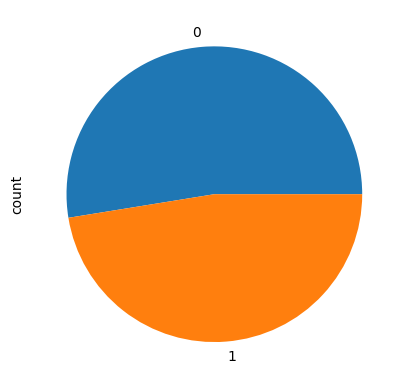

In [21]:
df_2['Risk Category'].value_counts().plot.pie()

## Correlation Between Heart Rate and Risk Category

In [22]:
# measures linear relationship between two continuos variable
# calculating Pearson correlation for checking the correlation between
# Heart rate and Risk Category

# ensure for numeric value
df_2['Heart Rate'] = pd.to_numeric(df_2['Heart Rate'],errors='coerce')
# df_corr = df_1.dropna(subset=['Heart Rate', 'Risk Category']) // optional if NULL data 
df_corr3 = df_2[['Heart Rate','Risk Category']]

In [23]:
df_corr3.head()

,Heart Rate,Risk Category
Patient ID,,
1,60,0
2,63,0
3,63,1
4,99,0
5,69,0


In [24]:
# point-biserial correlation
# measures correlation between where one variable is binary and oher is continuos
from scipy import stats
pb_r, pb_p = stats.pointbiserialr(df_corr3['Heart Rate'],df_corr3['Risk Category'])
print(f"point-biserial r={pb_r:.4f}, p={pb_p}")

point-biserial r=-0.3685, p=0.0


In [25]:
# this shows that for high risk it have high heart rate
# pb_p shows the statistical significance measures
# pb_p = 0 means correlation is statistically significant and real trust

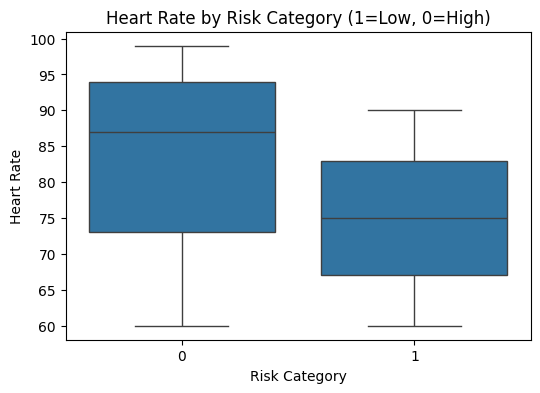

In [26]:
# Visualization between Heat Rate and Risk Category
plt.figure(figsize=(6,4))
sns.boxplot(x='Risk Category', y='Heart Rate', data=df_corr3)
plt.title('Heart Rate by Risk Category (1=Low, 0=High)')
plt.xlabel("Risk Category")
plt.ylabel("Heart Rate")
plt.show()

## Correlation Between Body Temperature and Risk Category

In [27]:
# ensure for numeric value
df_2['Body Temperature'] = pd.to_numeric(df_2['Body Temperature'],errors='coerce')
# df_corr = df_1.dropna(subsets=['Body Temperature','Risk Category])   # option if NULL
df_Corr_4 = df_1[['Body Temperature','Risk Category']]
df_Corr_4.head()

,Body Temperature,Risk Category
Patient ID,,
1,36.861707,0
2,36.511633,0
3,37.052049,1
4,36.654748,0
5,36.975098,0


In [28]:
# point-biserial correlation
pb_r, pb_p = stats.pointbiserialr(df_Corr_4['Body Temperature'],df_Corr_4['Risk Category'])
print(f"pb_r:{pb_r}, pb_p:{pb_p}")

pb_r:-0.0011813385586117954, pb_p:0.5972675637827833


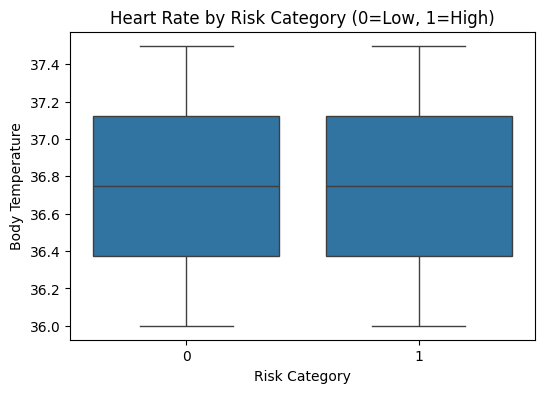

In [29]:
# Visualization between Heat Rate and Risk Category
plt.figure(figsize=(6,4))
sns.boxplot(x='Risk Category', y='Body Temperature', data=df_Corr_4)
plt.title('Heart Rate by Risk Category (0=Low, 1=High)')
plt.xlabel("Risk Category")
plt.ylabel("Body Temperature")
plt.show()

## Correlation between Oxygen Saturation and Risk Category

In [30]:
# ensore for numeric value
df_2['Oxygen Saturation'] = pd.to_numeric(df_2['Oxygen Saturation'],errors='coerce')
df_corr_5 = df_1[['Oxygen Saturation','Risk Category']]
df_corr_5.head()

,Oxygen Saturation,Risk Category
Patient ID,,
1,95.702046,0
2,96.689413,0
3,98.508265,1
4,95.011801,0
5,98.623792,0


In [31]:
# point biserial
pb_r, pb_p = stats.pointbiserialr(df_corr_5['Oxygen Saturation'],df_corr_5['Risk Category'])
print(f"pb_r: {pb_r}, pb_b: {pb_p}")

pb_r: 0.0006522071149840282, pb_b: 0.770524664729982


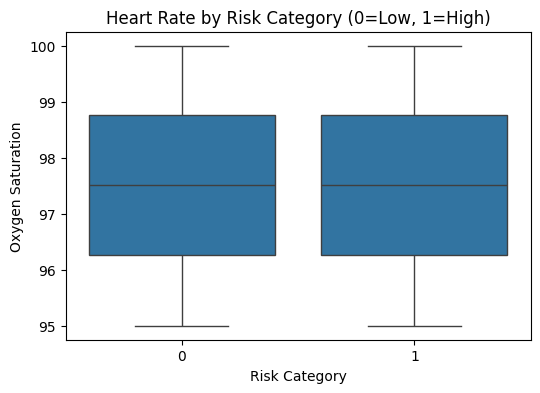

In [32]:
# Visualization between Heat Rate and Risk Category
plt.figure(figsize=(6,4))
sns.boxplot(x='Risk Category', y='Oxygen Saturation', data=df_corr_5)
plt.title('Heart Rate by Risk Category (0=Low, 1=High)')
plt.xlabel("Risk Category")
plt.ylabel("Oxygen Saturation")
plt.show()

## Correlation Between Age and Risk Category

In [33]:
df_2['Age'] = pd.to_numeric(df_2['Age'],errors='coerce')
df_corr_6 = df_1[['Age','Risk Category']]
df_corr_6.head()

,Age,Risk Category
Patient ID,,
1,37,0
2,77,0
3,68,1
4,41,0
5,25,0


In [34]:
# point biserial
pb_r, pb_p = stats.pointbiserialr(df_corr_6['Age'], df_corr_6['Risk Category'])
print(f"pb_r: {pb_r}, pb_p: {pb_p}")

pb_r: -0.0024659625816274454, pb_p: 0.27008713499660414


## Correlation between HRV and Risk Category

In [35]:
df_2['HRV'] = pd.to_numeric(df_2['HRV'], errors='coerce')
df_corr_7 = df_2[['HRV', 'Risk Category']]
df_corr_7.head()

,HRV,Risk Category
Patient ID,,
1,0.121033,0
2,0.117062,0
3,0.053200,1
4,0.064475,0
5,0.118484,0


In [36]:
# point biserial
pb_r, pb_p = stats.pointbiserialr(df_corr_7['HRV'], df_corr_7['Risk Category'])
print(f"pb_r: {pb_r}, pb_p: {pb_p}")

pb_r: 0.0015220698397249077, pb_p: 0.4960483626650552


In [37]:
# Visualization between Heat Rate and Risk Category
plt.figure(figsize=(6,4))
sns.boxplot(x='Risk Category', y='HRV', data=df_corr_5)
plt.title('Heart Rate by Risk Category (0=Low, 1=High)')
plt.xlabel("Risk Category")
plt.ylabel("HRV")    # Heart Rate Variability
plt.show()

ValueError: Could not interpret value `HRV` for `y`. An entry with this name does not appear in `data`.

<Figure size 600x400 with 0 Axes>

## Correlation Between Gender and Risk Category

In [ ]:
# checking correlation
pearson_8 = df_1['Gender'].corr(df_1['Risk Category'])
print(f"Pearson: {pearson_8}")

Pearson: 0.002528427053782683


## Dataframe to csv

In [ ]:
df_1.to_csv("Final Dataset.csv")